In [ ]:
import sys

!{sys.executable} -m pip uninstall torch torchvision torchaudio open_clip_torch -y
!{sys.executable} -m pip install torch==2.0.1 torchvision==0.15.2 open_clip_torch

In [1]:
import os
import json
import time
import urllib.request
import zipfile
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import imageio.v2 as imageio

DEVICE = 'cpu'
print(f"Running on {DEVICE}")

Running on cpu


In [2]:
if not os.path.exists('nerf_example_data') and not os.path.exists('nerf_synthetic'):
    print("Downloading dataset...")
    if os.path.exists('nerf_example_data.zip'): os.remove('nerf_example_data.zip')
    os.system("curl -L -o nerf_example_data.zip http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/nerf_example_data.zip")
    print("Extracting...")
    with zipfile.ZipFile('nerf_example_data.zip', 'r') as zip_ref:
        zip_ref.extractall('.')

# Функция загрузки
def load_blender_data(basedir):
    print(f"Loading from {basedir}...")
    with open(os.path.join(basedir, 'transforms_train.json'), 'r') as fp:
        meta = json.load(fp)

    imgs, poses = [], []
    for frame in meta['frames']:
        fname = os.path.join(basedir, frame['file_path'].replace('./', '') + '.png')
        imgs.append(imageio.imread(fname))
        poses.append(np.array(frame['transform_matrix']))

    # Нормализация и ресайз
    imgs = (np.array(imgs) / 255.).astype(np.float32)
    poses = np.array(poses).astype(np.float32)
    H, W = imgs.shape[1], imgs.shape[2]
    camera_angle_x = float(meta['camera_angle_x'])
    focal = .5 * W / np.tan(.5 * camera_angle_x)

    imgs = torch.from_numpy(imgs).to(DEVICE)
    poses = torch.from_numpy(poses).to(DEVICE)

    TARGET_H, TARGET_W = 200, 200 
    imgs = imgs.permute(0, 3, 1, 2)
    imgs = F.interpolate(imgs, size=(TARGET_H, TARGET_W), mode='area')
    imgs = imgs.permute(0, 2, 3, 1)
    focal = focal * (TARGET_H / H)

    # Белый фон
    if imgs.shape[-1] == 4:
        imgs = imgs[..., :3] * imgs[..., 3:4] + (1. - imgs[..., 3:4])

    return imgs, poses, focal

# Поиск и выполнение
def find_lego():
    for root, dirs, files in os.walk('.'):
        if 'transforms_train.json' in files and 'lego' in root: return root
    return None

path = find_lego()
if path:
    images, poses, focal = load_blender_data(path)
    H, W = images.shape[1], images.shape[2]
    print(f"Data ready: {H}x{W}, {len(images)} images")
else:
    print("ERROR: Dataset not found. Check download.")

Loading from ./nerf_synthetic/lego...
Data ready: 200x200, 100 images


In [3]:
import open_clip

print("Loading OpenCLIP...")
model, _, _ = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k', device=DEVICE)
model.eval()

def get_clip_features(images, model):
    print("Extracting features...")
    all_features = []
    grid_size = 7 
    
    with torch.no_grad():
        for i, img in enumerate(images):
            # Ресайз под вход CLIP 
            img_in = F.interpolate(img.permute(2,0,1).unsqueeze(0), size=(224,224), mode='bilinear', align_corners=False)
            # Нормализация
            mean = torch.tensor([0.481, 0.457, 0.408], device=DEVICE).view(1,3,1,1)
            std = torch.tensor([0.268, 0.261, 0.275], device=DEVICE).view(1,3,1,1)
            img_in = (img_in - mean) / std
            
            # Проход для получения патчей
            vis = model.visual
            x = vis.conv1(img_in.type(vis.conv1.weight.dtype))
            x = x.reshape(x.shape[0], x.shape[1], -1).permute(0, 2, 1)
            x = torch.cat([vis.class_embedding.to(x.dtype) + torch.zeros(x.shape[0], 1, x.shape[-1], device=DEVICE), x], dim=1)
            x = x + vis.positional_embedding.to(x.dtype)
            x = vis.ln_pre(x).permute(1, 0, 2)
            x = vis.transformer(x).permute(1, 0, 2)
            
            patches = x[:, 1:, :].reshape(1, grid_size, grid_size, -1).permute(0, 3, 1, 2)
            # Upsample 
            upsampled = F.interpolate(patches, size=(img.shape[0], img.shape[1]), mode='bilinear', align_corners=False)
            all_features.append(upsampled.squeeze(0).permute(1, 2, 0))
            
    return torch.stack(all_features)

# Вычисляем
raw_feats = get_clip_features(images, model)
proj = model.visual.proj.detach().to(DEVICE)
clip_features = F.normalize(raw_feats.view(-1, raw_feats.shape[-1]) @ proj, dim=-1).view(raw_feats.shape[0], H, W, -1)
EMBEDDING_DIM = clip_features.shape[-1]
print(f"CLIP Features ready: {clip_features.shape}")

Loading OpenCLIP...
Extracting features...
CLIP Features ready: torch.Size([100, 200, 200, 512])


In [11]:
# Positional Encoding
def pos_enc(x, L):
    out = [x]
    for i in range(L):
        out.append(torch.sin(2.0**i * np.pi * x))
        out.append(torch.cos(2.0**i * np.pi * x))
    return torch.cat(out, -1)

# Модель
class LeRFModel(nn.Module):
    def __init__(self, emb_dim=512, hidden=128):
        super().__init__()
        self.L_pos, self.L_dir = 10, 4
        in_pos = 3 + 6 * self.L_pos
        in_dir = 3 + 6 * self.L_dir
        
        self.base = nn.ModuleList([nn.Linear(in_pos, hidden)] + [nn.Linear(hidden, hidden) for _ in range(5)])
        self.sigma = nn.Linear(hidden, 1)
        self.feat = nn.Linear(hidden, hidden)
        self.rgb = nn.Sequential(nn.Linear(hidden + in_dir, hidden//2), nn.ReLU(), nn.Linear(hidden//2, 3), nn.Sigmoid())
        self.sem = nn.Sequential(nn.Linear(hidden, hidden), nn.ReLU(), nn.Linear(hidden, emb_dim))

    def forward(self, x, d):
        h = pos_enc(x, self.L_pos)
        for l in self.base: h = F.relu(l(h))
        
        sigma = F.softplus(self.sigma(h))
        geo = self.feat(h)
        rgb = self.rgb(torch.cat([geo, pos_enc(d, self.L_dir)], -1))
        sem = F.normalize(self.sem(geo), dim=-1)
        return sigma, rgb, sem

# Лучи
def get_rays(H, W, focal, c2w):
    i, j = torch.meshgrid(torch.arange(W), torch.arange(H), indexing='xy')
    dirs = torch.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -torch.ones_like(i)], -1).to(DEVICE)
    rays_d = torch.sum(dirs[..., None, :] * c2w[:3, :3], -1)
    rays_o = c2w[:3, 3].expand(rays_d.shape)
    return rays_o, rays_d

# Рендеринг
def render_rays(rays_o, rays_d, model, N_samples=128):
    z_vals = torch.linspace(2.0, 6.0, N_samples).to(DEVICE).expand(rays_o.shape[0], N_samples)
    if model.training: # Шум для сглаживания
        z_vals = z_vals + (torch.rand_like(z_vals) * (4.0/N_samples))
        
    pts = rays_o[..., None, :] + rays_d[..., None, :] * z_vals[..., :, None]
    raw_sigma, raw_rgb, raw_sem = model(pts.reshape(-1, 3), rays_d[:, None, :].expand(pts.shape).reshape(-1, 3))
    
    sigma = raw_sigma.reshape(rays_o.shape[0], N_samples)
    rgb = raw_rgb.reshape(rays_o.shape[0], N_samples, 3)
    sem = raw_sem.reshape(rays_o.shape[0], N_samples, -1)
    
    dists = z_vals[..., 1:] - z_vals[..., :-1]
    dists = torch.cat([dists, torch.tensor([1e10], device=DEVICE).expand(dists[..., :1].shape)], -1)
    
    alpha = 1. - torch.exp(-sigma * dists)
    weights = alpha * torch.cumprod(torch.cat([torch.ones((alpha.shape[0], 1), device=DEVICE), 1.-alpha + 1e-10], -1), -1)[:, :-1]
    
    rgb_map = torch.sum(weights[..., None] * rgb, -2) + (1. - torch.sum(weights, -1)[..., None])
    sem_map = F.normalize(torch.sum(weights[..., None] * sem, -2), dim=-1)
    depth_map = torch.sum(weights * z_vals, -1)
    
    return rgb_map, sem_map, depth_map

print("Model & Render functions ready")

Model & Render functions ready


Starting Training...
Step 0: Loss 0.2354, Time: 1.6s
Step 500: Loss 0.0284, Time: 771.8s
Step 1000: Loss 0.0184, Time: 1544.0s
Step 1500: Loss 0.0129, Time: 2301.9s
Step 2000: Loss 0.0156, Time: 3056.2s
Step 2500: Loss 0.0150, Time: 3813.6s
Step 3000: Loss 0.0148, Time: 4588.3s


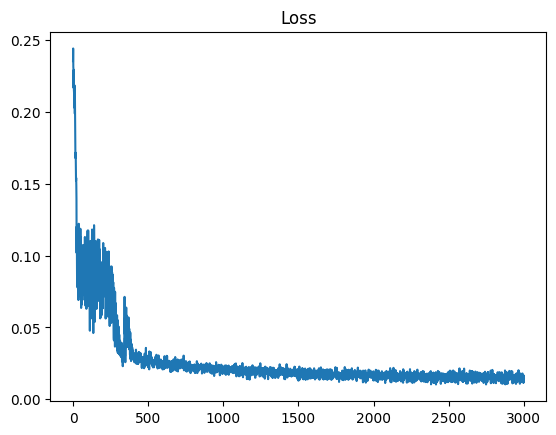

In [6]:
# Обучение
nerf_model = LeRFModel(emb_dim=EMBEDDING_DIM).to(DEVICE)
optimizer = optim.Adam(nerf_model.parameters(), lr=5e-4)

N_ITERS = 3001
BATCH_SIZE = 2048
loss_history = []

print("Starting Training...")
start = time.time()

for i in range(N_ITERS):
    img_i = np.random.randint(images.shape[0])
    
    # Случайные пиксели
    coords = torch.stack(torch.meshgrid(torch.arange(H), torch.arange(W), indexing='ij'), -1).reshape(-1, 2)
    select = coords[np.random.choice(coords.shape[0], BATCH_SIZE, replace=False)]
    
    # Лучи и таргеты
    rays_o, rays_d = get_rays(H, W, focal, poses[img_i])
    rays_o, rays_d = rays_o[select[:,0], select[:,1]], rays_d[select[:,0], select[:,1]]
    target_rgb = images[img_i][select[:,0], select[:,1]]
    target_sem = clip_features[img_i][select[:,0], select[:,1]]
    
    # Рендер
    rgb_pred, sem_pred, _ = render_rays(rays_o, rays_d, nerf_model)
    
    # Loss: MSE + Cosine
    loss = F.mse_loss(rgb_pred, target_rgb) + 0.04 * (1. - torch.mean(torch.sum(sem_pred * target_sem, -1)))
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Decay LR
    for g in optimizer.param_groups: g['lr'] = 5e-4 * (0.1 ** (i / N_ITERS))
    
    loss_history.append(loss.item())
    if i % 500 == 0: print(f"Step {i}: Loss {loss.item():.4f}, Time: {time.time()-start:.1f}s")

plt.plot(loss_history)
plt.title("Loss")
plt.show()

Rendering view...
Computing PCA...


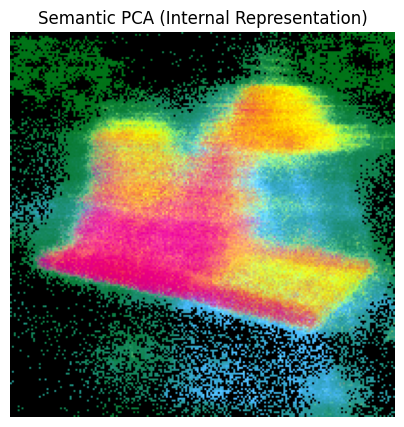

Querying: 'yellow'...


/opt/homebrew/Caskroom/miniforge/base/envs/o3d/lib/python3.10/site-packages/torch/nn/modules/activation.py:1160: UserWarning:

Converting mask without torch.bool dtype to bool; this will negatively affect performance. Prefer to use a boolean mask directly. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/transformers/attention.cpp:152.)



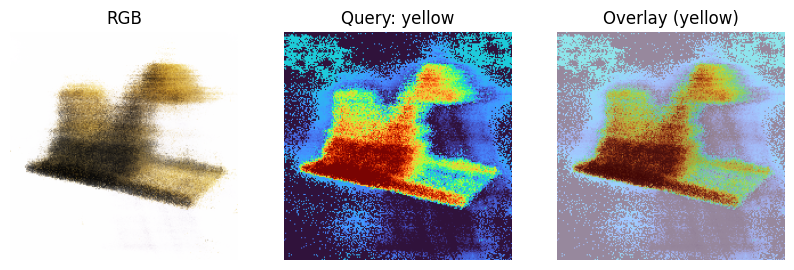

Querying: 'black'...


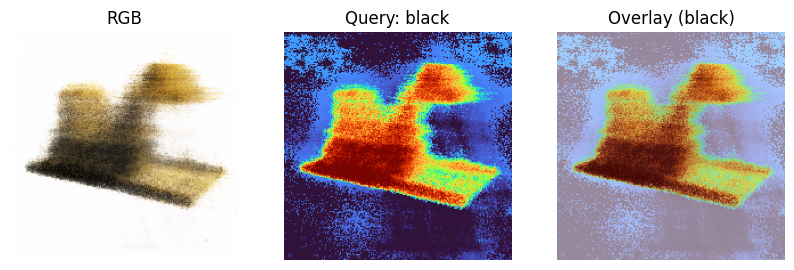

Querying: 'lego'...


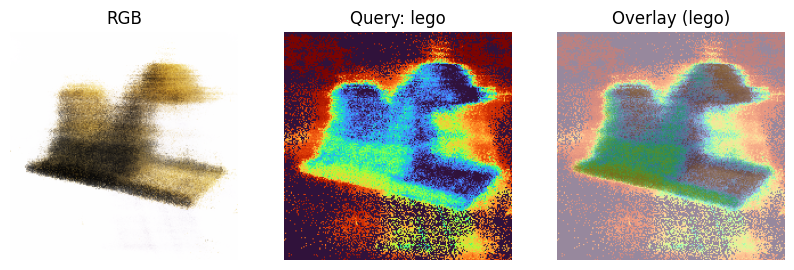

In [12]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from open_clip import tokenizer
from sklearn.decomposition import PCA

# Функция рендера полного кадра 
def render_full(pose):
    rays_o, rays_d = get_rays(H, W, focal, pose)
    flat_o, flat_d = rays_o.reshape(-1, 3), rays_d.reshape(-1, 3)
    out_rgb, out_sem, out_depth = [], [], []
    
    with torch.no_grad():
        # Чанк 2048
        for i in range(0, flat_o.shape[0], 2048):
            r, s, d = render_rays(flat_o[i:i+2048], flat_d[i:i+2048], nerf_model, N_samples=64)
            out_rgb.append(r.cpu()); out_sem.append(s.cpu()); out_depth.append(d.cpu())
            
    return (torch.cat(out_rgb).reshape(H,W,3).clamp(0,1), 
            torch.cat(out_sem).reshape(H,W,512), 
            torch.cat(out_depth).reshape(H,W))

def show_results(prompts=["yellow", "black"]):
    print("Rendering view...")
    # Здесь хороший ракурс на бульдозер
    pose = poses[10] 
    rgb, sem, depth = render_full(pose)
    
    # Маска объекта 
    mask = (depth > 2.0) & (depth < 6.0)
    
    # PCA Визуализация 
    print("Computing PCA...")
    valid_feats = sem[mask]
    
    if len(valid_feats) > 0:
        # Сжатие 512 каналов до 3-х главных компонент
        pca = PCA(n_components=3).fit_transform(valid_feats.numpy())
        
        # Нормализация
        pca_img = np.zeros((H, W, 3))
        for k in range(3):
            v = pca[:, k]
            # Растягиваем контраст 
            vmin, vmax = np.percentile(v, 1), np.percentile(v, 99)
            v_norm = np.clip((v - vmin) / (vmax - vmin), 0, 1)
            pca_img[mask, k] = v_norm
            
        plt.figure(figsize=(5,5))
        plt.imshow(pca_img)
        plt.title("Semantic PCA (Internal Representation)")
        plt.axis('off')
        plt.show()
    else:
        print("Error: Object mask is empty")

    # Текстовые запросы
    for p in prompts:
        print(f"Querying: '{p}'...")
        tokens = tokenizer.tokenize([p]).to(DEVICE)
        with torch.no_grad():
            text_emb = F.normalize(model.encode_text(tokens), dim=-1).cpu()
        
        # Считаем сходство
        sim = (sem.view(-1, 512) @ text_emb.T).view(H, W)
        
        # Smart Contrast
        vals = sim[mask]
        if len(vals) > 0:
            # Перцентили, чтобы отсечь выбросы
            s_min, s_max = torch.quantile(vals, 0.05), torch.quantile(vals, 0.95)
            
            sim_norm = (sim - s_min) / (s_max - s_min)
            sim_norm = sim_norm.clamp(0, 1)
            # Зануляем фон
            sim_norm[~mask] = 0.0
            
            plt.figure(figsize=(10,3))
            
            plt.subplot(1,3,1)
            plt.imshow(rgb)
            plt.title("RGB")
            plt.axis('off')
            
            plt.subplot(1,3,2)
            plt.imshow(sim_norm, cmap='turbo') 
            plt.title(f"Query: {p}")
            plt.axis('off')
            
            plt.subplot(1,3,3)
            plt.imshow(rgb, cmap='gray')
            plt.imshow(sim_norm, cmap='turbo', alpha=0.5)
            plt.title(f"Overlay ({p})")
            plt.axis('off')
            
            plt.show()

# Запускаем
show_results(prompts=["yellow", "black", "lego"])

In [10]:
import plotly.graph_objects as go
from sklearn.decomposition import PCA

def visualize_3d_pca(pose_idx=10):
    print("Generating 3D Semantic Pointcloud...")
    
    # Рендерим сцену
    target_pose = poses[pose_idx]
    rgb, sem, depth = render_full(target_pose)
    
    # Переводим в numpy
    depth_np = depth.cpu().numpy()
    sem_np = sem.cpu().numpy()
    
    # Маска объекта
    mask = (depth_np > 2.0) & (depth_np < 6.0)
    
    # Координаты точек
    i, j = np.meshgrid(np.arange(W), np.arange(H))
    z = depth_np
    x = (i - W * 0.5) / focal * z
    y = -(j - H * 0.5) / focal * z
    
    xyz_cam = np.stack([x[mask], y[mask], -z[mask]], axis=-1)
    
    # Transform to World
    c2w = target_pose.cpu().numpy()
    xyz_world = (xyz_cam @ c2w[:3, :3].T) + c2w[:3, 3]
    
    # Цвет точек (PCA)
    valid_feats = sem_np[mask]
    pca = PCA(n_components=3).fit_transform(valid_feats)
    
    # Нормализация PCA в RGB 
    pca_colors = np.zeros_like(pca)
    for k in range(3):
        v = pca[:, k]
        v_min, v_max = np.percentile(v, 1), np.percentile(v, 99)
        pca_colors[:, k] = np.clip((v - v_min) / (v_max - v_min), 0, 1)
    
    # Plotly
    fig = go.Figure(data=[go.Scatter3d(
        x=xyz_world[:, 0],
        y=xyz_world[:, 1],
        z=xyz_world[:, 2],
        mode='markers',
        marker=dict(
            size=4,
            color=pca_colors, 
            opacity=0.8
        ),
        hovertext=["Semantic Part"] * len(xyz_world)
    )])

    fig.update_layout(
        title="3D LeRF Semantic Fields (PCA Colors)",
        scene=dict(
            xaxis=dict(visible=False),
            yaxis=dict(visible=False),
            zaxis=dict(visible=False),
            aspectmode='data'
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )
    
    fig.show()

visualize_3d_pca()

Generating 3D Semantic Pointcloud...
